## DQNでエージェントを構築

In [1]:
import os
import random
from typing import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import copy
from collections import deque
import optuna

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchinfo

import ipytest
ipytest.autoconfig()

## オセロ環境

In [2]:
def opponent(c):
    """現在のプレイヤーの相手を返す"""
    return -c

EMPTY, BLACK, WHITE = 0, 1, -1
DIRECTIONS = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]

class Othello:
    def __init__(self):
        self.board = [[EMPTY for _ in range(8)] for _ in range(8)]
        self.board[3][3] = self.board[4][4] = WHITE
        self.board[3][4] = self.board[4][3] = BLACK
        self.player = BLACK

    def clone(self):
        """盤面をコピーして新しいインスタンスを返す"""
        g = Othello()
        g.board = [row[:] for row in self.board]
        g.player = self.player
        return g

    def inside(self, r, c):
        """
        盤面の範囲内かを返す
        Args:
            r (int): 行
            c (int): 列
        Returns:
            bool: 盤面の範囲内か
        """
        return 0 <= r < 8 and 0 <= c < 8

    def legal_moves(self, player=None) -> List[Tuple[int, int]]:
        """
        合法手を返す
        Args:
            player (int, optional): プレイヤーの色.指定しない場合は現在のプレイヤーを返す
        Returns:
            List[Tuple[int, int]]: 合法手のリスト
        """
        if player is None:
            player = self.player
        moves = []
        for r in range(8):
            for c in range(8):
                if self.board[r][c] != EMPTY:  # 空白でない場合は合法手ではない
                    continue
                if self._would_flip(r, c, player):  # 石をひっくり返せる場合は合法手
                    moves.append((r, c))
        return moves

    def _would_flip(self, r, c, player) -> bool:
        """
        石をひっくり返せるかを返す
        Args:
            r (int): 行
            c (int): 列
            player (int): プレイヤーの色
        Returns:
            bool: 石をひっくり返せるか
        """
        if self.board[r][c] != EMPTY:  # 空白でない場合は石をひっくり返せない
            return False
        for dr, dc in DIRECTIONS:
            rr, cc = r + dr, c + dc
            seen_opp = False  # 相手の石を一度見たか
            while self.inside(rr, cc) and self.board[rr][cc] == opponent(player):  # 盤面の範囲内か & 相手の石が置かれている場所か
                seen_opp = True
                rr += dr; cc += dc
            if seen_opp and self.inside(rr, cc) and self.board[rr][cc] == player:  # 相手の石を一度見たか & 盤面の範囲内か & 自分の石をみたか
                return True
        return False

    def play(self, r, c, player=None):
        """
        石を置く & 石をひっくり返す
        Args:
            r (int): 行
            c (int): 列
            player (int, optional): プレイヤーの色.指定しない場合は現在のプレイヤーを返す
        """
        if player is None:
            player = self.player
        assert self.board[r][c] == EMPTY  # 空白でない場合は石を置くことができない
        flipped = []
        for dr, dc in DIRECTIONS:
            line = []
            rr, cc = r + dr, c + dc
            while self.inside(rr,cc) and self.board[rr][cc] == opponent(player):  # 盤面の範囲内か & 相手の石が置かれている場所か
                line.append((rr,cc))  # 石をひっくり返す場所を追加
                rr += dr; cc += dc
            if line and self.inside(rr,cc) and self.board[rr][cc] == player:  # 石をひっくり返す場所が存在 & 盤面の範囲内か & 自分の石をみたか
                flipped.extend(line)  # 石をひっくり返す場所を追加
        if not flipped:  # 石をひっくり返す場所が存在しない場合は不正な手
            raise ValueError("Illegal move")
        self.board[r][c] = player
        for rr,cc in flipped:  # 石をひっくり返す
            self.board[rr][cc] = player
        self.player = opponent(player)
        # 現在のプレイヤーが合法手がない場合は相手の番
        if not self.legal_moves(self.player):
            self.player = opponent(self.player)

    def is_terminal(self) -> bool:
        """
        終局かを返す
        Returns:
            bool: 終局か
        """
        if self.legal_moves(BLACK): return False
        if self.legal_moves(WHITE): return False
        return True

    def game_score(self) -> int:
        """
        黒が+1, 白が-1としてスコアを計算
        Returns:
            int: スコア
        """
        s = 0
        for r in range(8):
            for c in range(8):
                s += self.board[r][c]
        return s

    def winner(self) -> int:
        s = self.game_score()
        return BLACK if s > 0 else WHITE if s < 0 else 0

### 報酬設計

In [3]:
class Reward:
    def __init__(
        self, player,
        weight_corner=1.0, weight_dangerous=-1.2,
        weight_mobility=1.0, weight_frontier=-0.6
    ):
        """
        Args:
            player (int): 手番
            weight_corner (float): 角の重み
            weight_dangerous (float): 危険な場所の重み
            weight_mobility (float): モビリティの重み
            weight_frontier (float): フロンティアの重み
        """
        self.player = player
        self.weight_corner = weight_corner
        self.weight_dangerous = weight_dangerous
        self.weight_mobility = weight_mobility
        self.weight_frontier = weight_frontier

    def get_reward(self, env: Othello):
        """
        Args:
            env (Othello): オセロ環境
        Returns:
            float: 報酬
        """
        if self._is_terminal(env):
            pc, oc = self._count_stones(env)
            # 勝敗ベースの終局報酬
            return 1.0 if pc > oc else (-1.0 if pc < oc else 0.0)

        phase = self._get_game_phase(env)

        # 角
        my_corner, op_corner = self._count_corner_stones(env)
        corner_term = self._safe_ratio(my_corner - op_corner, max(1, my_corner + op_corner))

        # 危険（X/C だけを見る）
        my_dang, op_dang = self._count_xc_danger(env)
        danger_term = self._safe_ratio(my_dang - op_dang, max(1, my_dang + op_dang))

        # モビリティ（相対値）
        my_mob = len(env.legal_moves(self.player))
        op_mob = len(env.legal_moves(opponent(self.player)))
        mobility_term = self._safe_ratio(my_mob - op_mob, max(1, my_mob + op_mob))

        # フロンティア（多いほど悪い → 符号反転）
        my_front, op_front = self._count_frontier(env)
        frontier_term = self._safe_ratio(my_front - op_front, max(1, my_front + op_front))

        if phase in (0, 1):  # 序・中盤
            reward = (
                self.weight_mobility * mobility_term +
                self.weight_corner   * corner_term +
                self.weight_dangerous * danger_term +
                self.weight_frontier * frontier_term
            )
        else:  # 後盤（石差を薄く採用）
            pc, oc = self._count_stones(env)
            disc_diff_term = self._safe_ratio(pc - oc, max(1, pc + oc))
            reward = 0.5 * (self.weight_corner * corner_term) \
                   + 0.3 * (self.weight_mobility * mobility_term) \
                   + 0.2 * disc_diff_term

        # クリップ
        return max(-1.0, min(1.0, reward))

    # ---------- 補助 ----------
    def _is_terminal(self, env: Othello):
        return (len(env.legal_moves(self.player)) == 0 and
                len(env.legal_moves(opponent(self.player))) == 0)

    def _safe_ratio(self, num, den):  # [-1,1] 目安
        return num / den if den != 0 else 0.0

    def _get_game_phase(self, env: Othello):
        pc, oc = self._count_stones(env)
        n = pc + oc
        if n <= 20:  # 序盤
            return 0
        elif n <= 45:  # 中盤
            return 1
        else:  # 後盤
            return 2

    def _count_stones(self, env: Othello):
        pc = oc = 0
        for r in range(8):
            for c in range(8):
                if env.board[r][c] == self.player: pc += 1
                elif env.board[r][c] == opponent(self.player): oc += 1
        return pc, oc

    def _count_corner_stones(self, env: Othello):
        corners = [(0,0),(0,7),(7,0),(7,7)]
        pc = oc = 0
        for r,c in corners:
            if env.board[r][c] == self.player: pc += 1
            elif env.board[r][c] == opponent(self.player): oc += 1
        return pc, oc

    def _count_xc_danger(self, env: Othello):
        # 角と対応する X/C だけを見る
        corners = [(0,0),(0,7),(7,0),(7,7)]
        X      = [(1,1),(1,6),(6,1),(6,6)]
        C      = [(0,1),(1,0),(0,6),(1,7),(6,0),(7,1),(6,7),(7,6)]
        pc = oc = 0
        # X
        for (xr,xc),(cr,cc) in zip(X,corners):
            if env.board[cr][cc] == EMPTY:
                if env.board[xr][xc] == self.player: pc += 1
                elif env.board[xr][xc] == opponent(self.player): oc += 1
        # C（対応角が空なら危険）
        for r,c in C:
            cr = 0 if r in (0,1) else 7
            cc = 0 if c in (0,1) else 7
            if env.board[cr][cc] == EMPTY:
                if env.board[r][c] == self.player: pc += 1
                elif env.board[r][c] == opponent(self.player): oc += 1
        return pc, oc

    def _count_frontier(self, env: Othello):
        pc = oc = 0
        for r in range(8):
            for c in range(8):
                cell = env.board[r][c]
                if cell == EMPTY:
                    continue
                # 隣に空きがあればフロンティア
                frontier = any(
                    0 <= r+dr < 8 and 0 <= c+dc < 8 and env.board[r+dr][c+dc] == EMPTY
                    for dr in (-1,0,1) for dc in (-1,0,1) if dr or dc
                )
                if frontier:
                    if cell == self.player: pc += 1
                    elif cell == opponent(self.player): oc += 1
        return pc, oc

### テスト

In [4]:
%%ipytest -qq


# オセロクラスの簡単な初期化テスト
def test_othello_init():
    env = Othello()

    # ボードのサイズ
    assert len(env.board) == 8
    assert all(len(row) == 8 for row in env.board)

    # 中心マスの初期配置
    assert env.board[3][3] == -1
    assert env.board[3][4] == 1
    assert env.board[4][3] == 1
    assert env.board[4][4] == -1

    # 中心ます以外は0
    for i in range(8):
        for j in range(8):
            if i == 3 and j in (3, 4):
                continue
            if i == 4 and j in (3, 4):
                continue
            assert env.board[i][j] == 0

    # 初手は黒（1）の番
    assert env.player == 1

.                                                                                            [100%]


In [5]:
%%ipytest -qq

BLACK = 1
WHITE = -1

# Rewardクラスのテスト
class TestReward:
    def setup_method(self):
        self.env = Othello()
        self.reward_black = Reward(BLACK)
        self.reward_white = Reward(WHITE)

    def test_init(self):
        assert self.reward_black.player == BLACK
        assert self.reward_white.player == WHITE

    def test_terminal_black_win(self):
        env = Othello()
        env.board = [[BLACK] * 8 for _ in range(8)]

        assert self.reward_black.get_reward(env) == 1
        assert self.reward_white.get_reward(env) == -1

    def test_terminal_draw(self):
        env = Othello()
        env.board = [[BLACK if (i + j) % 2 else WHITE for j in range(8)] for i in range(8)]

        assert self.reward_black.get_reward(env) == 0
        assert self.reward_white.get_reward(env) == 0

    def test_early_phase(self):
        env = Othello()

        # 序盤かを確認
        assert self.reward_black._get_game_phase(env) == 0

        # 初期配置パターンでの報酬を確認
        reward_black = self.reward_black.get_reward(env)
        reward_white = self.reward_white.get_reward(env)
        assert abs(reward_black) < 1e-5
        assert abs(reward_white) < 1e-5

....                                                                                         [100%]


## DQNのネットワーク定義

In [6]:
class DSConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.dw = nn.Conv2d(
            in_channels=in_channels, out_channels=in_channels,
            kernel_size=3, padding=1, groups=in_channels, bias=False,
        )
        self.pw = nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=1, bias=False,
        )
        self.gn = nn.GroupNorm(num_groups=1, num_channels=out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        x = self.dw(x)
        x = self.pw(x)
        x = self.gn(x)
        x = self.act(x)
        return x


class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=8,
                kernel_size=3, padding=1, bias=False,
            ),
            nn.SiLU(),
        )
        self.block1 = DSConv(in_channels=8, out_channels=8)
        self.block2 = DSConv(in_channels=8, out_channels=8)

        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8, out_features=64),
            nn.SiLU(),
        )
        self.head = nn.Linear(in_features=64, out_features=65)  # 65番目は、パスの行動

    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.gap(x)
        x = self.fc(x)
        x = self.head(x)
        return x

In [7]:
# アーキテクチャのテスト
dqn = DQN()
dummy_input = torch.zeros((1, 1, 8, 8))
print(dqn(dummy_input).shape)
torchinfo.summary(dqn, (1, 1, 8, 8))

torch.Size([1, 65])


Layer (type:depth-idx)                   Output Shape              Param #
DQN                                      [1, 65]                   --
├─Sequential: 1-1                        [1, 8, 8, 8]              --
│    └─Conv2d: 2-1                       [1, 8, 8, 8]              72
│    └─SiLU: 2-2                         [1, 8, 8, 8]              --
├─DSConv: 1-2                            [1, 8, 8, 8]              --
│    └─Conv2d: 2-3                       [1, 8, 8, 8]              72
│    └─Conv2d: 2-4                       [1, 8, 8, 8]              64
│    └─GroupNorm: 2-5                    [1, 8, 8, 8]              16
│    └─SiLU: 2-6                         [1, 8, 8, 8]              --
├─DSConv: 1-3                            [1, 8, 8, 8]              --
│    └─Conv2d: 2-7                       [1, 8, 8, 8]              72
│    └─Conv2d: 2-8                       [1, 8, 8, 8]              64
│    └─GroupNorm: 2-9                    [1, 8, 8, 8]              16
│    └─SiLU: 2-

## DQNの学習

In [8]:
class ReplayBuffer:
    def __init__(self, memory_size):
        self.memory_size = memory_size
        self.memory = deque(maxlen=memory_size)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [9]:
import copy
import math
import random
from typing import Dict, List, Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm


class TrainDoubleDQN:
    """
    Othello 用 Double DQN 学習クラス
    - Double DQN: a' = argmax_a Q_online(s', a), target = r + γ (1-done) Q_target(s', a')
    - 行動 0..63 が盤面、64 がパス
    """

    def __init__(
        self,
        dqn,  # nn.Module 互換 (B,1,8,8) -> (B,65)
        gamma: float = 0.99,
        lr: float = 1e-3,
        batch_size: int = 64,
        init_memory_size: int = 5000,
        memory_size: int = 50000,
        target_update_freq: int = 1000,   # ハード更新の頻度（steps）
        tau: float = 0.0,                 # >0 で Polyak (soft) 更新。0 ならハード更新。
        num_episodes: int = 1000,
        max_steps_per_episode: int = 200,
        train_freq: int = 1,              # 何ステップに一回アップデートするか
        gradient_steps: int = 1,          # 1 回の学習トリガで何回更新するか
        learning_starts: int = 1000,      # これ未満は収集のみ
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.05,
        epsilon_decay_steps: int = 30000, # ステップ単位で減衰
        seed: int = 42,
        device: Optional[torch.device] = None,
        ReplayBufferCls=None,             # 既存の ReplayBuffer を差す
    ):
        assert ReplayBufferCls is not None, "ReplayBufferCls を渡してください（既存の ReplayBuffer クラス）"
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # RNG 固定
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

        self.dqn = dqn.to(self.device)
        self.target_dqn = copy.deepcopy(dqn).to(self.device)
        self.target_dqn.eval()

        self.optimizer = optim.Adam(self.dqn.parameters(), lr=lr)
        self.loss_fn = nn.SmoothL1Loss()

        self.gamma = gamma
        self.batch_size = batch_size
        self.init_memory_size = init_memory_size
        self.max_steps_per_episode = max_steps_per_episode
        self.num_episodes = num_episodes

        self.train_freq = max(1, int(train_freq))
        self.gradient_steps = max(1, int(gradient_steps))
        self.learning_starts = int(learning_starts)

        self.tau = float(tau)
        self.target_update_freq = int(target_update_freq)
        self._num_updates = 0
        self._num_env_steps = 0

        # ε を「ステップ単位」で減衰
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_steps = max(1, int(epsilon_decay_steps))

        # リプレイバッファ
        self.replay_buffer = ReplayBufferCls(memory_size)

        # 事前収集
        self._init_replay_buffer()

        self.rewards: List[float] = []
        self.losses: List[float] = []

    # =====================
    # 公開 API
    # =====================
    def train(self) -> Dict[str, List[float]]:
        pbar = tqdm.tqdm(total=self.num_episodes, desc="Train Double DQN")
        for ep in range(self.num_episodes):
            ep_reward = self._run_episode(ep)
            self.rewards.append(ep_reward)

            last_loss = self.losses[-1] if self.losses else float("nan")
            pbar.set_postfix_str(f"EpR: {ep_reward:.2f}  Loss: {last_loss:.3f}  ε: {self._epsilon_by_step(self._num_env_steps):.3f}")
            pbar.update(1)
        pbar.close()
        return {"rewards": self.rewards, "losses": self.losses}

    # =====================
    # エピソード実行
    # =====================
    def _run_episode(self, episode_idx: int) -> float:
        env = Othello()
        total_reward = 0.0
        steps = 0

        while not env.is_terminal() and steps < self.max_steps_per_episode:
            epsilon = self._epsilon_by_step(self._num_env_steps)

            # ★ここで事前に現在盤面をコピー（観測 s）
            board_before = copy.deepcopy(env.board)
            player = env.player

            action = self._select_action_by_epsilon_greedy(env, epsilon)

            # 1 ステップ進める
            if action == 64:
                env.player = -player
            else:
                r, c = self._action_to_rc(action)
                env.play(r, c, player)

            reward = self.compute_reward(env, player)
            done = env.is_terminal()

            # ★board_before を保存（s）
            self._store_transition(
                board=board_before,
                action=action,
                reward=reward,
                next_board=env.board,  # s'
                done=done,
                player=player,
                next_player=env.player,
                force_read_prev_from_env=False,
            )

            # 学習（一定間隔・ウォームアップ後）
            if (self._num_env_steps % self.train_freq == 0) and (len(self.replay_buffer) >= max(self.batch_size, self.learning_starts)):
                for _ in range(self.gradient_steps):
                    loss = self._update_dqn_double()
                    if not math.isnan(loss):
                        self.losses.append(loss)

            # ターゲット更新
            self._maybe_update_target()

            total_reward += float(Reward(player).get_reward(env))
            steps += 1
            self._num_env_steps += 1

        return float(total_reward)

    # =====================
    # Double DQN アップデート
    # =====================
    def _update_dqn_double(self) -> float:
        batch = self.replay_buffer.sample(self.batch_size)

        # (B,1,8,8)
        board = torch.stack([self._to_1x8x8(b['board']) for b in batch]).to(self.device)
        next_board = torch.stack([self._to_1x8x8(b['next_board']) for b in batch]).to(self.device)

        action = torch.tensor([b['action'] for b in batch], dtype=torch.int64, device=self.device)
        reward = torch.tensor([b['reward'] for b in batch], dtype=torch.float32, device=self.device)
        done = torch.tensor([b['done'] for b in batch], dtype=torch.float32, device=self.device)
        player = torch.tensor([b['player'] for b in batch], dtype=torch.int64, device=self.device)
        next_player = torch.tensor([b['next_player'] for b in batch], dtype=torch.int64, device=self.device)
        next_legal_actions_list = [b['next_legal_actions'] for b in batch]

        # Q(s,a)（現在ネット）
        q_all = self.dqn(board)                                 # (B,65)
        q_sa = q_all.gather(1, action.unsqueeze(1)).squeeze(1)  # (B,)

        with torch.no_grad():
            # --- Double DQN: オンラインで argmax（次状態） ---
            # 合法手マスク（次状態用）
            next_masks = self._build_masks_from_indices(next_legal_actions_list)  # (B,65) with 0 or -inf
            q_next_online = self.dqn(next_board) + next_masks
            next_actions_online = q_next_online.argmax(dim=1)  # (B,)

            # ターゲットで評価
            q_next_target = self.target_dqn(next_board)
            next_q = q_next_target.gather(1, next_actions_online.unsqueeze(1)).squeeze(1)  # (B,)

            target = reward + self.gamma * next_q * (1.0 - done)

        # 損失と更新
        loss = self.loss_fn(q_sa, target)
        if torch.isnan(loss):
            return float("nan")

        self.optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.dqn.parameters(), max_norm=1.0)
        self.optimizer.step()

        self._num_updates += 1
        return float(loss.item())

    # =====================
    # 行動選択
    # =====================
    def _select_action_by_epsilon_greedy(self, env, epsilon: float) -> int:
        legal_rc = env.legal_moves(env.player)
        if len(legal_rc) == 0:
            return 64  # パス

        if random.random() < epsilon:
            r, c = random.choice(legal_rc)
            return self._rc_to_action(r, c)
        return self._select_action_by_greedy(env)

    def _select_action_by_greedy(self, env) -> int:
        legal_rc = env.legal_moves(env.player)
        if len(legal_rc) == 0:
            return 64

        board_tensor = self._to_1x8x8(env.board).unsqueeze(0).to(self.device)  # (1,1,8,8)
        with torch.no_grad():
            q_all = self.dqn(board_tensor).squeeze(0)  # (65,)
            mask = torch.full((65,), float('-inf'), device=self.device)
            for r, c in legal_rc:
                mask[self._rc_to_action(r, c)] = 0.0
            # 合法手があるときはパスは原則無効
            q_masked = q_all + mask
            action = int(q_masked.argmax().item())
        return action

    # =====================
    # 事前収集
    # =====================
    def _init_replay_buffer(self):
        target = min(self.init_memory_size, self.replay_buffer.memory_size)
        added = 0
        pbar = tqdm.tqdm(total=target, desc='Init replay buffer')
        while added < target:
            env = Othello()
            done = False
            while not done and added < target:
                # _init_replay_buffer 内の while ループ
                player = env.player
                board_before = copy.deepcopy(env.board)   # ★ここ
                legal_actions = env.legal_moves(player)
                if len(legal_actions) == 0:
                    action = 64
                    env.player = -player
                else:
                    r, c = random.choice(legal_actions)
                    action = self._rc_to_action(r, c)
                    env.play(r, c, player)

                reward = self.compute_reward(env, player)
                done = env.is_terminal()
                self._store_transition(
                    board=board_before,
                    action=action,
                    reward=reward,
                    next_board=env.board,
                    done=done,
                    player=player,
                    next_player=env.player,
                    force_read_prev_from_env=False,
                )
                added += 1
                pbar.update(1)
        pbar.close()

    # =====================
    # ターゲット更新
    # =====================
    def _maybe_update_target(self):
        if self.tau and self.tau > 0.0:
            # Polyak
            with torch.no_grad():
                for tp, p in zip(self.target_dqn.parameters(), self.dqn.parameters()):
                    tp.data.mul_(1.0 - self.tau).add_(self.tau * p.data)
        else:
            # ハード
            if (self._num_updates % max(1, self.target_update_freq)) == 0 and self._num_updates > 0:
                self.target_dqn.load_state_dict(self.dqn.state_dict())

    # =====================
    # ε スケジュール（ステップ）
    # =====================
    def _epsilon_by_step(self, step: int) -> float:
        # 線形減衰（終端で epsilon_end にクリップ）
        if step >= self.epsilon_decay_steps:
            return self.epsilon_end
        span = self.epsilon_start - self.epsilon_end
        return self.epsilon_start - span * (step / self.epsilon_decay_steps)

    # =====================
    # マスク生成
    # =====================
    def _build_legal_action_masks(self, boards: torch.Tensor, players: torch.Tensor) -> torch.Tensor:
        """
        boards: (B,1,8,8) on device
        players: (B,)
        return: (B,65) 0 or -inf
        """
        B = boards.shape[0]
        masks = torch.full((B, 65), float('-inf'), device=boards.device)
        # バッチで Othello を都度立て直す（環境が軽い前提）
        for i in range(B):
            env_tmp = Othello()
            env_tmp.board = boards[i].squeeze(0).detach().cpu().numpy().tolist()
            env_tmp.player = int(players[i].item())
            legal_rc = env_tmp.legal_moves(env_tmp.player)
            if len(legal_rc) == 0:
                masks[i, 64] = 0.0
            else:
                for r, c in legal_rc:
                    masks[i, self._rc_to_action(r, c)] = 0.0
        return masks

    # =====================
    # 低レベル補助
    # =====================
    def _action_to_rc(self, action: int) -> Tuple[int, int]:
        return divmod(int(action), 8)

    def _rc_to_action(self, row: int, col: int) -> int:
        return row * 8 + col

    def _to_1x8x8(self, board) -> torch.Tensor:
        """
        入力を (1,8,8) tensor に正規化（その後 Stack で (B,1,8,8) になる想定）
        """
        if board is None:
            # フォールバック（ありえない場合は呼び出し元で直近盤面を再採取）
            board = [[0]*8 for _ in range(8)]
        t = torch.as_tensor(board, dtype=torch.float32)
        if t.dim() == 2 and t.shape == (8, 8):
            t = t.unsqueeze(0)
        elif t.dim() == 4 and t.shape[1:] == (1, 8, 8):
            t = t.squeeze(1)
        elif t.dim() == 3 and t.shape == (1, 8, 8):
            pass
        else:
            t = t.reshape(1, 8, 8)[0:1]
        return t

    def compute_reward(self, next_env, player: int) -> float:
        try:
            r = Reward(player).get_reward(next_env)
        except Exception:
            r = 0.0
        return float(r)

    def _store_transition(
        self,
        board,
        action: int,
        reward: float,
        next_board,
        done: bool,
        player: int,
        next_player: int,
        force_read_prev_from_env: bool = False,
    ):
        """
        board / next_board は (8x8) 互換配列 or (1,8,8) 互換で OK
        """
        env_tmp = Othello()
        env_tmp.board = board
        env_tmp.player = player
        legal_rc = env_tmp.legal_moves(next_player)

        if len(legal_rc) == 0:
            next_player_actions = [64]
        else:
            next_player_actions = [self._rc_to_action(r, c) for r, c in legal_rc]
        # 一部の Othello 実装は「直前盤面」を持たない想定があるので、必要なら再取得

        transition = {
            "board": self._to_1x8x8(board),
            "action": int(action),
            "reward": float(reward),
            "next_board": self._to_1x8x8(next_board),
            "done": bool(done),
            "player": int(player),
            "next_player": int(next_player),
            "next_legal_actions": next_player_actions,
        }
        self.replay_buffer.append(transition)

    def _build_masks_from_indices(self, batch_next_legal_actions):
        """
        batch_next_legal_actions: (B,) of list[int]
        return: (B,65)
        """
        B = len(batch_next_legal_actions)
        masks = torch.full((B, 65), float('-inf'), device=self.device)
        for i, acts in enumerate(batch_next_legal_actions):
            for a in acts:
                masks[i, a] = 0.0
        return masks

    def _safe_copy_board(self, env, previous=False):
        """
        一部の環境で前盤面を保持している場合だけ使うための安全コピー
        """
        if previous and hasattr(env, "prev_board"):
            return copy.deepcopy(env.prev_board)
        return copy.deepcopy(env.board)

In [10]:
dqn = DQN()
train_dqn = TrainDoubleDQN(dqn, ReplayBufferCls=ReplayBuffer)
print("init_memory_size =", train_dqn.init_memory_size, "memory_size =", train_dqn.replay_buffer.memory_size)
print("len(memory) before =", len(train_dqn.replay_buffer.memory))

Init replay buffer: 100%|██████████| 5000/5000 [00:02<00:00, 2469.84it/s]

init_memory_size = 5000 memory_size = 50000
len(memory) before = 5000


In [11]:
memory = train_dqn.replay_buffer.memory
list_done = [m['done'] for m in memory]
print("done count =", list_done.count(True), "/", len(list_done), list_done.count(True) / len(list_done))

done count = 83 / 5000 0.0166


In [12]:
# デバイスの設定
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

num_episodes = 10000
gamma = 0.99
lr = 5e-4
target_update_freq = 2000
batch_size = 128

epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay_steps = 20000

replay_buffer_cls = ReplayBuffer

dqn = DQN()

trainer = TrainDoubleDQN(
    dqn,
    device=device,
    num_episodes=num_episodes,
    gamma=gamma,
    lr=lr,
    target_update_freq=target_update_freq,
    batch_size=batch_size,
    epsilon_start=epsilon_start,
    epsilon_end=epsilon_end,
    epsilon_decay_steps=epsilon_decay_steps,
    ReplayBufferCls=replay_buffer_cls,
)

res = trainer.train()
rewards = res["rewards"]

Using device: mps


Train Double DQN:  12%|█▏        | 1240/10000 [30:14<3:51:06,  1.58s/it, EpR: -3.27  Loss: 0.091  ε: 0.050]

KeyboardInterrupt: 

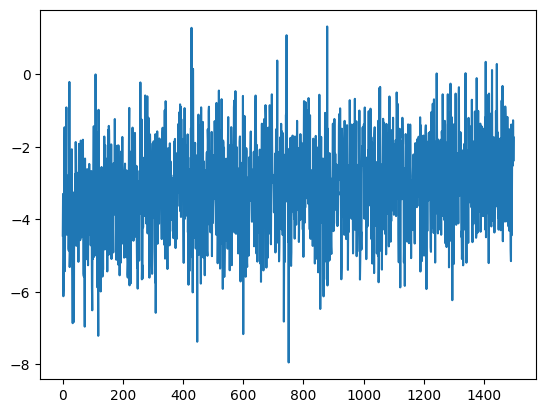

In [ ]:
plt.plot(rewards)
plt.show()